# Figure 5. DROSHA cleavage sites
---

In [1]:
import time
today = time.strftime('%Y-%m-%d')
name = 'Seungchan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by Seungchan Baek at 2021-01-20.


In [2]:
home = '/casa/bsc/projects/1_DCS/2004_paper_prep/'
%cd $home

/casa/bsc/projects/1_DCS/2004_paper_prep


In [3]:
from __future__ import division
import sys; sys.path.append('/casa/bsc/notebooks/')
from util import *
from basic import gen_result_dir
resultpath = gen_result_dir('results/')
print 'resultpath:', resultpath

resultpath: results/210120/


In [4]:
import pandas as pd
import numpy as np
import re
import gzip
from matplotlib import pyplot as plt
from matplotlib import gridspec, lines
from collections import defaultdict, Counter
from sequtil import rev_com_dna
%matplotlib inline

In [5]:
LIBRARIES = [ 'set1', 'set2', 'set3', 'set4', 'set5' ]

In [6]:
s1 = pd.read_csv('supplementary/TableS1__Previously_identified_DROSHA-dependence.csv', 
                 header=1, index_col=0)
s2 = pd.read_csv('supplementary/TableS2__Oligonucleotides_used_in_this_study.csv', 
                 header=1, index_col=0).fillna('')
s3 = pd.read_csv('supplementary/TableS3__In_vitro_processing_results_Microprocessor-only.csv',
                 header=1, index_col=0)

In [7]:
constseqs = dict(s2['Construct sequence (125 nt)'])
print len(constseqs)

1881


In [8]:
preposition = {}
for mir in s2.index:
    flank5, flank3 = s2.loc[mir,["5' flanking segment","3' flanking segment"]]
    if flank5 or flank3:
        preposition[mir] = (len(flank5)+1,125-len(flank3))
    else:
        preposition[mir] = (0,126)
print len(preposition), preposition['hsa-mir-142']

1881 (32, 90)


In [9]:
drodep = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA-dependent')>=0)].index
droind = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA-independent')>=0)].index
droko = s1[s1['DROSHA dependency'].apply(lambda x:x.find('DROSHA KO')>=0)].index
fclip = s1[s1['DROSHA dependency'].apply(lambda x:x.find('fCLIP')>=0)].index
print len(drodep), len(droind), len(droko), len(fclip)

311 257 157 281


In [10]:
EFFCUT = 1.5
HOMCUT = .25
effs = s3['Cleavage Efficiency'].to_dict()
homs = s3['Cleavage Homogeneity'].to_dict()
dcsmirs = [ m for m in s3.index if effs[m]>=EFFCUT and homs[m]>=HOMCUT ]
nodcs = [ m for m in s3.index if m not in dcsmirs ]
print len(s3.index), len(dcsmirs), len(nodcs)

1816 560 1256


In [11]:
majorcs = {}
for mir in dcsmirs:
    c5, c3 = s3.loc[[mir],["5' cleavage site","3' cleavage site"]].iloc[0]
    majorcs[mir] = (int(c5),int(c3))
print len(majorcs), majorcs['hsa-let-7a-1']

560 (25, 96)


# A. Cleavage site mapped

In [26]:
def parse_line(row):
    for s in row['attr'].split(';'):
        tag, value = s.split('=')
        row[tag] = value
    return row

In [27]:
# miBRase v21 gff file
gff = 'supplementary/human_mirbase-v21.gff3'
anntbl = pd.read_table(gff, header=12, sep='\t', usecols=[0,2,3,4,6,8], 
                       names=['chr','kind','start','end','strand','attr'])
anntbl = anntbl.apply(parse_line, axis=1).drop(['attr'], axis=1)
anntbl.head(3)

,Alias,Derives_from,ID,Name,chr,end,kind,start,strand
0,MI0022705,NaN,MI0022705,hsa-mir-6859-1,chr1,17436,miRNA_primary_transcript,17369,-
1,MIMAT0027618,MI0022705,MIMAT0027618,hsa-miR-6859-5p,chr1,17431,miRNA,17409,-
2,MIMAT0027619,MI0022705,MIMAT0027619,hsa-miR-6859-3p,chr1,17391,miRNA,17369,-


In [16]:
annpri = anntbl[anntbl['kind']=='miRNA_primary_transcript'].set_index('Name')
annmat = anntbl[anntbl['kind']=='miRNA'].set_index('ID')
allpris = sorted(annpri.index)
print len(allpris)

1881


In [17]:
# pri-mature matching
primat = {}
for pri, row in annpri.iterrows():
    matureDerives = anntbl[anntbl['Derives_from']==row['ID']]
    primat[pri] = matureDerives['Name'].tolist()
print primat['hsa-let-7a-1']

['hsa-let-7a-5p', 'hsa-let-7a-3p']


In [18]:
hpnseqf = 'supplementary/hairpin_mirbase-v21.fa'
matseqf = 'supplementary/mature_mirbase-v21.fa'
hpnseqs = { s.id:str(s.seq) for s in SeqIO.parse(hpnseqf, 'fasta') }
matseqs = { s.id:str(s.seq) for s in SeqIO.parse(matseqf, 'fasta') }
print len(hpnseqs)

28645


In [19]:
def determine_arm(pri, mat):
    preseq = s2.loc[pri,'Pre-miRNA']
    matseq = matseqs[mat]
    if preseq.startswith(matseq):
        return '5p'
    else:
        return '3p'

In [31]:
# miRBase hairpin
diff5, diff3 = {}, {}
for pri in dcsmirs:
    cs, ce = majorcs[pri]
    const = constseqs[pri].replace('T','U')
    for mat in primat[pri]:
        arm = determine_arm(pri,mat)
        if arm=='5p':
            diff5[pri] = cs-(const.find(matseqs[mat])+1)
        else:
            diff3[pri] = (125-const[::-1].find(matseqs[mat][::-1]))-ce
print len(diff5), len(diff3)

449 457


In [34]:
data5 = [ len([m for m in dcsmirs if m in diff5 and diff5[m]==0]), 
         len([m for m in dcsmirs if m not in diff5]),
         len([m for m in dcsmirs if m in diff5 and diff5[m]!=0]) ]
data3 = [ len([m for m in dcsmirs if m in diff3 and diff3[m]==0]), 
         len([m for m in dcsmirs if m not in diff3]),
         len([m for m in dcsmirs if m in diff3 and diff3[m]!=0]) ]
colors = [ '#757575', '#1c9099', '#7570b3' ]
print data5, sum(data5), map(lambda x: round(x,0), np.array(data5)/sum(data5)*100)
print data3, sum(data3), map(lambda x: round(x,0), np.array(data3)/sum(data3)*100)

[342, 85, 107] 534 [64.0, 16.0, 20.0]
[236, 77, 221] 534 [44.0, 14.0, 41.0]


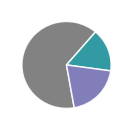

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(2,2))
ps,ts = ax.pie(data, colors=colors, wedgeprops={'linewidth':1.5,'edgecolor':'w','alpha':.9},
               startangle=-80, counterclock=False)
fig.savefig(resultpath + 'tmp.pdf')

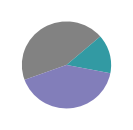

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(2,2))
ps,ts = ax.pie(data, colors=colors, wedgeprops={'linewidth':0,'edgecolor':'w','alpha':.9},
               startangle=200, counterclock=False)
fig.savefig(resultpath + '201116_f4b__3site.pdf')

In [12]:
consi = len([m for m in s3.index if m in fclip and m in dcsmirs])
incon = len([m for m in s3.index if m in fclip and m in nodcs])
print consi, incon

192 83


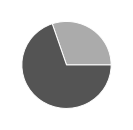

In [13]:
data = [incon, consi]
colors = [ '#ababab','#545454' ]
fig, ax = plt.subplots(1, 1, figsize=(2,2))
ps,ts = ax.pie(data, colors=colors, wedgeprops={'linewidth':1,'edgecolor':'w'})
#fig.savefig(resultpath + '210112_f5a__fclip_comp.pdf')

## Comparing cleavage sites with fCLIP-seq

In [35]:
from matplotlib_venn import venn2, venn2_circles

In [37]:
data = [ len([m for m in dcsmirs if m not in fclip]),
         len([m for m in fclip if m not in dcsmirs]),
         len([m for m in dcsmirs if m in fclip]) ]
fcolors = ['#cdcdcd', '#cdcdcd', '#858585']
ecolors = ['k', 'k','k' ]
tcolors = ['k','k','w']
print data

[346, 93, 188]


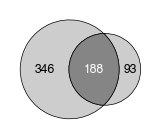

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5))

out = venn2(subsets=data, set_labels=('',''), ax=ax)
for text,c in zip(out.subset_labels, tcolors):
    text.set_fontsize(12.2)
    text.set_color(c)
    
for patch, fc, ec in zip(out.patches, fcolors, ecolors):
    patch.set_color(fc)
    patch.set_edgecolor(ec)
    patch.set_linewidth(.7)
    patch.set_alpha(1)
#fig.savefig(resultpath + 'tmp.pdf')

## C. Comparison cases

In [14]:
fclipexcel = pd.ExcelFile('supplementary/Kim_2017_s2.xlsx')
fclip293t = fclipexcel.parse('HEK293T_miRBase', index_col=0)
fcliphela = fclipexcel.parse('HeLa_miRBase', index_col=0)
both293t = fclip293t[(fclip293t['Group5p']!='Unidentified')
                     &(fclip293t['Group3p']!='Unidentified')]
bothhela = fcliphela[(fcliphela['Group5p']!='Unidentified')
                     &(fcliphela['Group3p']!='Unidentified')]

In [15]:
ivpcs5, ivpcs3 = {}, {}
for mir in dcsmirs:
    cs, ce, strand = s2.loc[mir,['Start','End','Strand']]
    if s3.loc[mir,'Cleavage ratio of alternative site']>=HOMCUT:
        if strand=='+':
            ivpcs5[mir] = map(int,[cs+s3.loc[mir,"5' cleavage site"]-1,
                           cs+s3.loc[mir,"5' alternative site"]-1])
            ivpcs3[mir] = map(int,[cs+s3.loc[mir,"3' cleavage site"]-1,
                           cs+s3.loc[mir,"3' alternative site"]-1])
        else:
            ivpcs5[mir] = map(int,[ce-s3.loc[mir,"5' cleavage site"]+1,
                           ce-s3.loc[mir,"5' alternative site"]+1])
            ivpcs3[mir] = map(int,[ce-s3.loc[mir,"3' cleavage site"]+1,
                           ce-s3.loc[mir,"3' alternative site"]+1])
    else:
        if strand=='+':
            ivpcs5[mir] = map(int,[cs+s3.loc[mir,"5' cleavage site"]-1])
            ivpcs3[mir] = map(int,[cs+s3.loc[mir,"3' cleavage site"]-1])
        else:
            ivpcs5[mir] = map(int,[ce-s3.loc[mir,"5' cleavage site"]+1])
            ivpcs3[mir] = map(int,[ce-s3.loc[mir,"3' cleavage site"]+1])

In [16]:
comptypes = defaultdict(list)
for mir in sorted(dcsmirs):
    ivp5cs = ivpcs5[mir]
    ivp3cs = ivpcs3[mir]
    if mir in both293t.index:
        fcl5cs = map(int, str(both293t.loc[mir, 'fCLIPPosition5p']).split(';'))
        fcl3cs = map(int, str(both293t.loc[mir, 'fCLIPPosition3p']).split(';'))
    elif mir in bothhela.index:
        fcl5cs = map(int, str(bothhela.loc[mir, 'fCLIPPosition5p']).split(';'))
        fcl3cs = map(int, str(bothhela.loc[mir, 'fCLIPPosition3p']).split(';'))
    else:
        continue
    
    if ivp5cs and fcl5cs:
        if set(ivp5cs)==set(fcl5cs):
            comptypes['I'].append(mir)
        elif set(ivp5cs)>=set(fcl5cs):
            comptypes['II'].append(mir)
        elif set(fcl5cs)>=set(ivp5cs):
            comptypes['III'].append(mir)
        else:
            comptypes['IV'].append(mir)

In [17]:
for t in 'I II III IV'.split():
    print t, len(comptypes[t])

I 158
II 6
III 8
IV 20


## E. Quantitative comparison

In [18]:
bedcols = [ 'chr', 'start', 'end', 'rname', 'miRNA', 'strand' ]
bedfile = 'supplementary/fCLIP/293T/293T_191115_genome-annot_1881-pris_mp1_sp1.bed.gz'
ftbl = pd.read_table(gzip.open(bedfile,'rb'),usecols=[0,1,2,3,15,17],names=bedcols)
ftbl['start']=ftbl['start']+1
ftbl.head(1)

,chr,start,end,rname,miRNA,strand
0,chr1,17311,17415,MG00HS17:985:HV7GYBCXX:2:1107:14995:57900,hsa-mir-6859-1,-


In [19]:
sub = ftbl[ftbl['miRNA']=='hsa-mir-6808']
print Counter(sub['end'])

Counter({1339668: 3, 1339631: 3, 1339641: 3, 1339648: 2, 1339650: 2, 1339653: 2, 1339663: 2, 1339672: 2, 1339708: 2, 1339633: 2, 1339643: 2, 1339649: 1, 1339651: 1, 1339652: 1, 1339657: 1, 1339658: 1, 1339661: 1, 1339666: 1, 1339759: 1, 1339669: 1, 1339671: 1, 1339780: 1, 1339675: 1, 1339805: 1, 1339760: 1, 1339684: 1, 1339686: 1, 1339699: 1, 1339700: 1, 1339704: 1, 1339707: 1, 1339710: 1, 1339711: 1, 1339752: 1, 1339614: 1, 1339751: 1, 1339624: 1, 1339625: 1, 1339796: 1, 1339627: 1, 1339629: 1, 1339758: 1, 1339632: 1, 1339764: 1, 1339766: 1, 1339776: 1, 1339768: 1, 1339770: 1, 1339644: 1, 1339645: 1})


In [21]:
rcut = 5
pvivo = {}
for mir in set(ftbl['miRNA']):
    ps, pe, strand = get_pre_annot(mir)[1:4]
    sub = ftbl[ftbl['miRNA']==mir]
    if strand=='+':
        sub = sub[sub['end'].apply(lambda x: x in range(ps-4,ps+3))]
        if len(sub)>=rcut:
            pvivo[mir] = [ len(sub[sub['end']==p])/len(sub) for p in range(ps-4,ps+3) ]
    else:
        sub = sub[sub['start'].apply(lambda x: x in range(pe-2,pe+5))]
        if len(sub)>=rcut:
            pvivo[mir] = [ len(sub[sub['start']==p])/len(sub) for p in range(pe-2,pe+5)[::-1] ]
print len(pvivo)

312


In [22]:
clvraw = pd.read_csv('supplementary/TableSub__cleavage_products_Microprocessor.csv',index_col=0)
clvraw = clvraw.set_index(['Pri-miRNA','rstart','rend'])
clvtbl = pd.DataFrame()
for lib in LIBRARIES:
    clvtbl[lib] = clvraw[['%s-1'%lib,'%s-2'%lib]].sum(axis=1)
clvtbl = clvtbl.reset_index()
clvtbl.head(1)

/casa/bsc/.local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Pri-miRNA,rstart,rend,set1,set2,set3,set4,set5
0,hsa-let-7a-1,1,8,4.0,4.0,0.0,0.0,0.0


In [23]:
start, mid, end = 1, 63, 125
clv5f = clvtbl[(clvtbl['rstart']==start)&(clvtbl['rend']<mid)].set_index('Pri-miRNA')
clv3f = clvtbl[(clvtbl['rstart']>mid)&(clvtbl['rend']==end)].set_index('Pri-miRNA')
clvhn = clvtbl[(clvtbl['rstart']<mid)&(clvtbl['rend']>mid)]
clvn5 = clvhn[clvhn['rstart']==start]
clvn3 = clvhn[clvhn['rend']==end]
clvh = clvhn.drop(clvn5.index).drop(clvn3.index).set_index('Pri-miRNA')
clvn5 = clvn5.set_index('Pri-miRNA'); clvn3 = clvn3.set_index('Pri-miRNA')

In [24]:
def fill_unfound(tbl):
    found = set(tbl.index)
    unfound = [ mir for mir in s2.index if mir not in found ]
    fill = pd.DataFrame(index=unfound, columns=tbl.columns).fillna(0)
    return tbl.append(fill)

In [25]:
clvtbl = fill_unfound(clvtbl.set_index('Pri-miRNA'))
clv5f = fill_unfound(clv5f)
clv3f = fill_unfound(clv3f)
clvh = fill_unfound(clvh)
clvn5 = fill_unfound(clvn5)
clvn3 = fill_unfound(clvn3)

In [26]:
def get_frac_5frag(mir):
    sub = clv5f.loc[[mir]].set_index('rend')
    return (sub/sub.sum())

In [27]:
rcut = 30
pvitro = {}
for mir in pvivo.keys():
    ps, pe = preposition[mir]
    sub = clv5f.loc[[mir]].set_index('rend').reindex(range(ps-4,ps+3)).fillna(0)['set1']
    if sub.sum()>=rcut:
        frac5 = sub/sub.sum()
        pvitro[mir] = frac5.tolist()
print len(pvitro)

296


In [28]:
ms = [ m for m in pvitro if m in dcsmirs ]
print len(ms)
klds = {}
for m in ms:
    p1s = pvivo[m]
    p2s = pvitro[m]
    kld = sum([p1*np.log(p1/p2) if p2>0 and p1>0 else 0 for p1,p2 in zip(p1s,p2s)])
    klds[m] = kld
print len(klds)

182


In [29]:
sortms = sorted(ms, key=lambda x:klds[x])
xs = range(len(ms))
ys = [ klds[m] for m in sortms ]
xs2 = [ sortms.index(m) for m in ['hsa-let-7a-1','hsa-let-7d','hsa-mir-10a','hsa-mir-30c-2'] ]
ys2 = [ klds[m] for m in ['hsa-let-7a-1','hsa-let-7d','hsa-mir-10a','hsa-mir-30c-2'] ]
xs3 = [ sortms.index(m) for m in ['hsa-mir-142','hsa-mir-17'] ]
ys3 = [ klds[m] for m in ['hsa-mir-142','hsa-mir-17'] ]
print xs2,ys2,xs3,ys3

[7, 84, 128, 164] [0.006905837180821381, 0.0973886991601535, 0.2443950528086697, 0.9553861835218207] [179, 178] [3.387919213382165, 3.122854925126233]


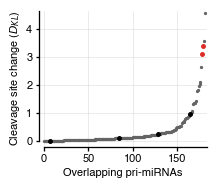

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(3,2.5))
ax.scatter(xs,ys,color='#646464',zorder=2,s=5,rasterized=True)
ax.scatter(xs2,ys2,color='k',zorder=3,s=15,marker='o',rasterized=True)
ax.scatter(xs3,ys3,color='#de2d26',zorder=3,s=15,marker='o',rasterized=True)
ax.set_xlabel('Overlapping pri-miRNAs')
ax.set_ylabel('Cleavage site change ($D_{KL}$)')
ax.set_xlim(-5, len(ms)+1)
ax.set_ylim(-.2,max(ys)+.1)
ax.spines['bottom'].set_bounds(0,len(ms)+1)
ax.spines['left'].set_bounds(0,max(ys)+.1)
ax.grid(ls='-',lw=.5)
#fig.savefig(resultpath + '201123__f5e_quantitative_comparison.pdf',dpi=300)